In [1]:
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')


#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Tue Mar 26 08:06:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| 41%   34C    P8               4W / 260W |     24MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
from dm_control import mujoco
from dm_control.rl import control
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib

from IPython.display import HTML, display
from tqdm import tqdm

import os

In [3]:
def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [7]:
from dm_control.rl import control
from dm_control.suite import base

from math import pi

class TestTask(base.Task):
    def __init__(self, random=None):
        super().__init__(random=random)

    def before_step(self, action, physics):
        np.copyto(physics.data.mocap_pos[0], action[0:3])

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        np.copyto(physics.data.mocap_pos[0], [-0.174,  1.184,  0.061])
        np.copyto(physics.data.mocap_quat[0], [ 0.   , -0.707,  0.707,  0.   ])
        
        super().initialize_episode(physics)

    def get_observation(self, physics):
        return {
            "images": {
                "top": physics.render(height=240, width=320, camera_id=0),
                "birdview": physics.render(height=240, width=320, camera_id=1),
                "front": physics.render(height=240, width=320, camera_id=2),
            },
            'mocap': {
                'pos': physics.data.mocap_pos[0],
                'quat': physics.data.mocap_quat[0],
            }
        }

    def get_reward(self, physics):
        return 0.0

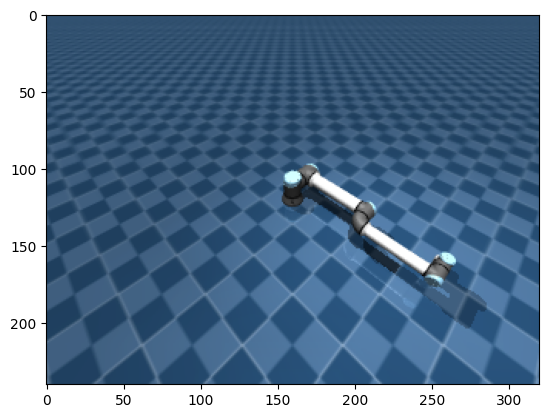

In [12]:
xml_path = os.path.join('./assets', 'scene.xml')
physics = mujoco.Physics.from_xml_path(xml_path)

task = TestTask()
env = control.Environment(physics, task, time_limit=10., control_timestep=0.2, n_sub_steps=None, flat_observation=False)

ts = env.reset()
plt.imshow(ts.observation['images']['birdview'])

In [14]:
mocap_pos = ts.observation['mocap']['pos']
mocap_pos = np.array([mocap_pos[0], mocap_pos[1], mocap_pos[2]+0.1])
print(np.concatenate([mocap_pos, ts.observation['mocap']['quat']]))
ts = env.step(mocap_pos)

for i in tqdm(range(100)):
    ts = env.step(mocap_pos)

[-0.174       1.184       0.161       0.         -0.70710678  0.70710678
  0.        ]


100%|██████████| 100/100 [00:05<00:00, 18.11it/s]
